In [1]:
!pip install pretrainedmodels

     |████████████████████████████████| 61kB 1.4MB/s eta 0:00:011
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60962 sha256=8ef80cb4010ff44d04a8485a0e8c29ce5f4a9965781f49b210d5cc5bdc4163a3
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models#, transforms

from torchvision import transforms as T


import matplotlib.pyplot as plt

import torch.nn.functional as F
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
import pretrainedmodels
import os
from torch.utils.data import Dataset
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import time
import numpy as np
import pandas as pd
import os
import datetime as dt
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# from torchvision.models import resnet18
# from collections import OrderedDict
from torchsummary import summary

%matplotlib inline

PyTorch Version:  1.5.0+cu101
Torchvision Version:  0.6.0+cu101


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data_path = "./data/train/train"
test_path = "./data/test/test"
extraimage_path = "./data/extraimages/extraimages"

In [3]:
print('Train set:')
class_distrbution = {}
for cls in os.listdir(data_path):
    print('{}:{}'.format(cls, len(os.listdir(os.path.join(data_path, cls)))))
    class_distrbution[cls] =  len(os.listdir(os.path.join(data_path, cls)))
im = Image.open(data_path+'/cgm/train-cgm-738.jpg')
print(im.size)
class_distrbution

Train set:
cmd:2658
healthy:316
cgm:773
cbb:466
cbsd:1443
(500, 500)


{'cbb': 466, 'cbsd': 1443, 'cgm': 773, 'cmd': 2658, 'healthy': 316}

In [4]:
# # Transformations for both the training and testing data
# mean=[0.4543, 0.5137, 0.3240]
# std=[0.1949, 0.1977, 0.1661]

mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]


# train_transforms = transforms.Compose([transforms.RandomRotation(30),
#                                        transforms.RandomResizedCrop(224), #448, 299, 224, 331
#                                        transforms.RandomHorizontalFlip(),
#                                        transforms.ToTensor(),
#                                       transforms.Normalize(mean=mean,std=std)])

# test_transforms = transforms.Compose([ transforms.Resize(224),
#                                        transforms.CenterCrop(224),
#                                        transforms.ToTensor(),
#                                       transforms.Normalize(mean=mean,std=std)])

# # normalize = transforms.Normalize(mean=mean, std=std)

In [5]:
# A function to perform color distortion in images
# It is used in SimCLR alongwith random resized cropping
# Here, s is the strength of color distortion.

def get_color_distortion(s = 1.0):
    color_jitter = T.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
    rnd_color_jitter = T.RandomApply([color_jitter], p=0.8)
    
    # p is the probability of grayscale, here 0.2
    rnd_gray = T.RandomGrayscale(p=0.2)
    color_distort = T.Compose([rnd_color_jitter, rnd_gray])
    
    return color_distort

In [6]:
class CassavaDataset(Dataset):
    def __init__(self, path, mode = 'train'):
        self.classes = os.listdir(path)
        self.path = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.mode = mode
        self.valid_transform = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224), #448, 299, 224, 331
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std)])
        
        self.test_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std)])
        

        files = []
        class_names = {}
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])

                name = str(i)+'-'+className
                if name not in class_names:
                    class_names[name] = 1
                else:
                    class_names[name] += 1
        self.file_list = files
#         print(class_names)
        files = None

    def tensorify(self, img):
        res = T.ToTensor()(img)
        res = T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(res)
        return res

    def mutate_image(self, img):
        res = T.RandomResizedCrop(224)(img)
        res = get_color_distortion(1)(res)
        return res

    
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        classCategory = self.file_list[idx][0]
        image = Image.open(fileName)
        
#         image = T.Resize((250, 250))(image)


        if self.mode == 'mutation':
            image1 = self.mutate_image(image)
            image1 = self.tensorify(image1)
            image2 = self.mutate_image(image)
            image2 = self.tensorify(image2)
            
            sample = {'image1': image1, 'image2': image2, 'label': classCategory}
            
#             return image1, image2, classCategory
        elif self.mode == 'train':
            
#             image = T.Resize((224, 224))(image)
#             image = self.tensorify(image)
            image = self.valid_transform(image)
            
            sample = {'image': image, 'label': classCategory}
            
        elif self.mode == 'test':
            image = self.test_transforms(image)
            
            sample = {'image': image, 'label': classCategory}
            
            
#             return image, classCategory

        return sample

In [7]:
train_data = CassavaDataset(data_path, mode = 'train')

test_data = CassavaDataset(test_path, mode = 'test')

extraimage_data = CassavaDataset(extraimage_path, mode = 'mutation') #maybe need an other trasforms, I had to change the dataset structure :)

In [10]:
# extraimage_data

In [11]:
# from torch.utils.data.sampler import SubsetRandomSampler

# validation_split = 0.2
# shuffle_dataset = True
# random_seed= 42 #42

# # Creating data indices for training and validation splits:
# dataset_size = len(train_data)
# indices = list(range(dataset_size))
# split = int(np.floor(validation_split * dataset_size))

# if shuffle_dataset :
#     np.random.seed(random_seed)
#     np.random.shuffle(indices)

# train_indices, val_indices = indices[split:], indices[:split]

In [12]:
# # Creating PT data samplers and loaders:
# train_sampler = SubsetRandomSampler(train_indices)
# valid_sampler = SubsetRandomSampler(val_indices)

# batch_size_train = 16# 125
# batch_size_eval = 16 #250
# n_workers = 2

# train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size_train,
#                                              sampler = train_sampler, num_workers = n_workers)

# valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size_eval,
#                                              sampler = valid_sampler, num_workers = n_workers)

# unlabeled_loader = torch.utils.data.DataLoader(extraimage_data, batch_size = batch_size_eval, 
#                                               num_workers = n_workers)

# # unlabeled_loader = torch.utils.data.DataLoader(extraimage_data, batch_size = batch_size_eval, 
# #                                               shuffle = True, num_workers = n_workers) # to make batch_size work, I had to moove all the unlabeled data in a 0 folder

# # test_loader = torch.utils.data.DataLoader(test_data, batch_size=1) # make batch = 1 here 

In [8]:
# Creating PT data samplers and loaders:
# train_sampler = SubsetRandomSampler(train_indices)
# valid_sampler = SubsetRandomSampler(val_indices)
from torch.utils.data.sampler import SubsetRandomSampler,WeightedRandomSampler
#-----------------------------------------------------------------------------z

validation_split = 0.2
shuffle_dataset = True
random_seed= 42

# ipdb.set_trace()
# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]


# get target

targets=[]
#data=[]
file_list =train_data.file_list
np.random.shuffle(file_list)

for i in file_list:
    targets.append(i[0])
   # data.append(i[2])
    
target_train=targets[split:]
# train_set=data[split:]
# print(len(train_set))

target_test=targets[:split]
#test_set=data[:split]



    
# for i in test_data.file_list:
#     test_targets.append(i[0])
    
# target = torch.cat((torch.zeros(int(len(train_data) * 0.99), dtype=torch.long),
#                     torch.ones(int(len(train_data) * 0.01), dtype=torch.long)))


#count classes
class_count = np.unique(target_train ,return_counts=True)[1]
#print(class_count)
class_count_test= np.unique(target_test, return_counts=True)[1]


#--------------------------------------------------------------------
# get weights train

weight_train = 1. / class_count
#print(targets)
samples_weight_train = weight_train[target_train]
#print(samples_weight_train )

samples_weight_train = torch.from_numpy(samples_weight_train)
#print(samples_weight_train)
sampler_train = WeightedRandomSampler(samples_weight_train, len(samples_weight_train))

#### valid



weight_test = 1. / class_count_test
#print(targets)
samples_weight_test = weight_test[target_test]
#print(samples_weight_train )

samples_weight_test = torch.from_numpy(samples_weight_test)
#print(samples_weight_train)
sampler_valid = WeightedRandomSampler(samples_weight_test, len(samples_weight_test))


train_loader = torch.utils.data.DataLoader(train_data, batch_size = 16,
                                             sampler = sampler_train)


valid_loader = torch.utils.data.DataLoader(train_data, batch_size = 16,
                                             sampler = sampler_valid)


unlabeled_loader = torch.utils.data.DataLoader(extraimage_data, batch_size = 16, 
                                              shuffle = True, num_workers = 2) # to make batch_size work, I had to moove all the unlabeled data in a 0 folder

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1) # make batch = 1 here 

In [9]:
# train_loader

In [10]:

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std=[1/s for s in std]
)

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = inv_normalize(img)# / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.figure(figsize=(20,20))
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

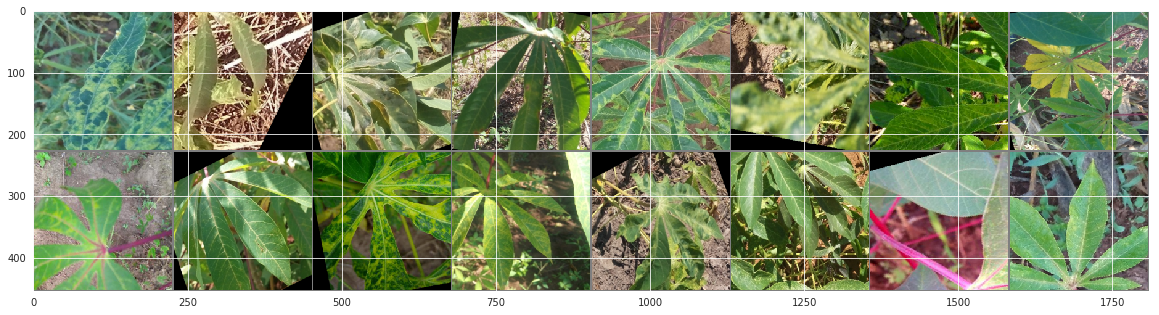

In [51]:
dataiter = iter(train_loader)

output = dataiter.next()

images, labels = output['image'], output['label']

# print(labels)
img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=False)

For augmented data

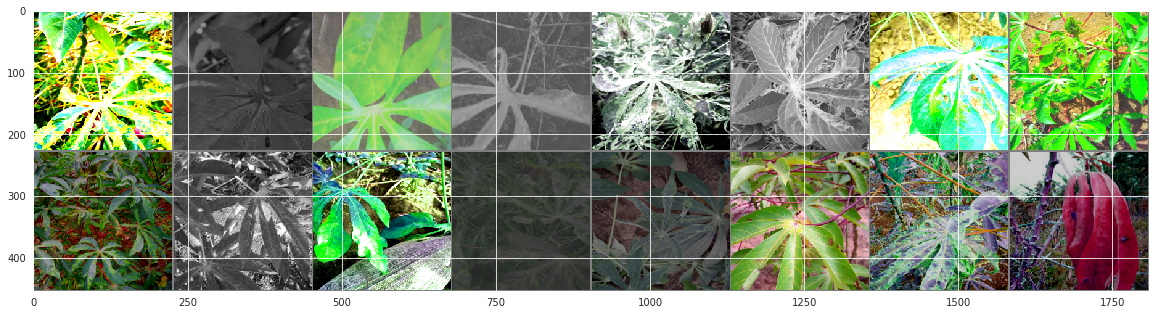

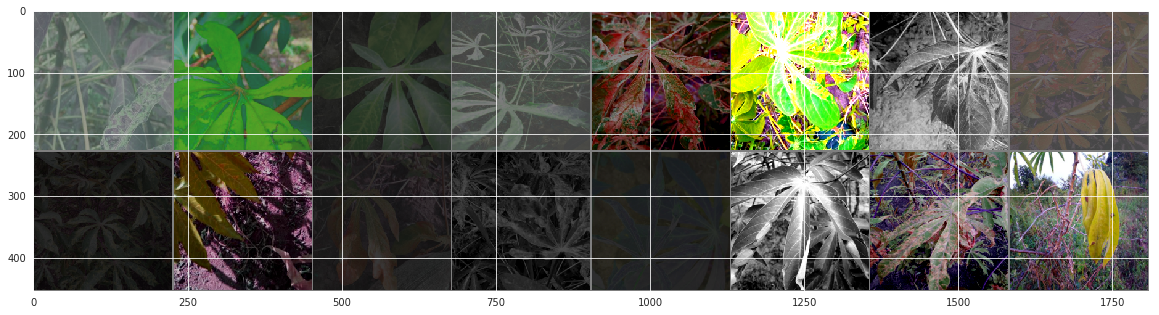

In [52]:
dataiter = iter(unlabeled_loader)

output = dataiter.next()

images_1, images_2, labels = output['image1'], output['image2'], output['label']

img_grid_1 = torchvision.utils.make_grid(images_1)
img_grid_2 = torchvision.utils.make_grid(images_2)

# Image 1
matplotlib_imshow(img_grid_1, one_channel=False)
# Image 2
matplotlib_imshow(img_grid_2, one_channel=False)

In [11]:
class Additional(nn.Module):
    def __init__(self, modelA,in_features,nb_classes=5, freeze = False):
        super(Additional, self).__init__()
        self.modelA = modelA
        # Remove last linear layer
#         self.modelA.fc = nn.Identity() # for resnet
        self.modelA.last_linear = nn.Identity() #for re_renext
#         self.modelA.classifier = nn.Identity()    # densenet201
        for p in self.modelA.parameters():
            if freeze:
                p.requires_grad = False
            else :
                p.requires_grad = True
        
        # Create new classifier
        self.fc_1 = nn.Linear(in_features,256)
        self.fc_2 = nn.Linear(256,  512)
        self.fc_out = nn.Linear( 512, nb_classes)
        
        #Dropout
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        #model
        x = self.modelA(x.clone())  
        x = x.view(x.size(0), -1)
        
        #FC
        x  = self.dropout(self.fc_1(F.relu(x)))
        x = self.dropout(self.fc_2(F.relu(x)))
        x = self.fc_out(F.relu(x))
        
        return x

In [12]:
# Code for NT-Xent Loss function, explained in more detail in the article

tau = 0.05 # best is 0.1 (to be checked)

def loss_function(a, b):
    a_norm = torch.norm(a, dim=1).reshape(-1, 1)
    a_cap = torch.div(a, a_norm)
    b_norm = torch.norm(b, dim=1).reshape(-1, 1)
    b_cap = torch.div(b, b_norm)
    a_cap_b_cap = torch.cat([a_cap, b_cap], dim=0)
    a_cap_b_cap_transpose = torch.t(a_cap_b_cap)
    b_cap_a_cap = torch.cat([b_cap, a_cap], dim=0)
    sim = torch.mm(a_cap_b_cap, a_cap_b_cap_transpose)
    sim_by_tau = torch.div(sim, tau)
    exp_sim_by_tau = torch.exp(sim_by_tau)
    sum_of_rows = torch.sum(exp_sim_by_tau, dim=1)
    exp_sim_by_tau_diag = torch.diag(exp_sim_by_tau)
    numerators = torch.exp(torch.div(torch.nn.CosineSimilarity()(a_cap_b_cap, b_cap_a_cap), tau))
    denominators = sum_of_rows - exp_sim_by_tau_diag
    num_by_den = torch.div(numerators, denominators)
    neglog_num_by_den = -torch.log(num_by_den)
    return torch.mean(neglog_num_by_den)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'se_resnext101_32x4d' # se_resnext101_32x4d, resnext101_64x4d, nasnetlarge
# resnet_model = torch.hub.load('pytorch/vision:v0.5.0', model_name, pretrained=True)
# resnet_model = pretrainedmodels.se_resnet50(num_classes=1000, pretrained="imagenet")

# todo : how to pretrained=False ?
resnet_model = pretrainedmodels.se_resnext101_32x4d(num_classes=1000, pretrained="imagenet")#None)

# num_fits = resnet_model.fc.in_features
num_fits = resnet_model.last_linear.in_features # se_resnext101_32x4d
# num_fits = resnet_model.classifier.in_features # densenet201
num_fits


# linear = Additional(resnet_model, num_fits, freeze = False)

# linear = linear.to(device)

model = resnet_model.to(device)
# model

#---------------------------------------------

lr = 2e-4 # 0.001
# criterion = nn.CrossEntropyLoss()


# using SGD optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# Code for NT-Xent Loss function, explained in more detail in the article

tau = 0.05 # best is 0.1 (to be checked)

def loss_function(a, b):
    a_norm = torch.norm(a, dim=1).reshape(-1, 1)
    a_cap = torch.div(a, a_norm)
    b_norm = torch.norm(b, dim=1).reshape(-1, 1)
    b_cap = torch.div(b, b_norm)
    a_cap_b_cap = torch.cat([a_cap, b_cap], dim=0)
    a_cap_b_cap_transpose = torch.t(a_cap_b_cap)
    b_cap_a_cap = torch.cat([b_cap, a_cap], dim=0)
    sim = torch.mm(a_cap_b_cap, a_cap_b_cap_transpose)
    sim_by_tau = torch.div(sim, tau)
    exp_sim_by_tau = torch.exp(sim_by_tau)
    sum_of_rows = torch.sum(exp_sim_by_tau, dim=1)
    exp_sim_by_tau_diag = torch.diag(exp_sim_by_tau)
    numerators = torch.exp(torch.div(torch.nn.CosineSimilarity()(a_cap_b_cap, b_cap_a_cap), tau))
    denominators = sum_of_rows - exp_sim_by_tau_diag
    num_by_den = torch.div(numerators, denominators)
    neglog_num_by_den = -torch.log(num_by_den)
    return torch.mean(neglog_num_by_den)

criterion = loss_function

# optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [14]:
# # can view the summary if you like
# model.to(device)
# summary(model, (3, 224, 224))

In [15]:
# Defining data structures for storing training info

losses_train = []
num_epochs = 20

lr = 2e-4

# using SGD optimizer
optimizer = optim.Adam(model.parameters(), lr=lr) #optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

if not os.path.exists('results'):
    os.makedirs('results')

# load pretrained model, optimizer and training losses file if model.pth file is available
if(os.path.isfile("results/model.pth")):
    model.load_state_dict(torch.load("results/model.pth"))
    optimizer.load_state_dict(torch.load("results/optimizer.pth"))

    for param_group in optimizer.param_groups:
        param_group['weight_decay'] = 1e-6
        param_group['lr'] = 0.000003

    temp = np.load("results/lossesfile.npz")
    losses_train = list(temp['arr_0'])

In [16]:
total_loss_train, total_acc_train = [],[]

losses_train = []

def get_mean_of_list(L):
    return sum(L) / len(L)

def train_SimCLR(unlabeled_loader, model, criterion, optimizer, num_epochs):
    
    # get resnet in train mode
    model.train()
    
#     train_loss = AverageMeter()
#     train_acc = AverageMeter()
#     curr_iter = (2 - 1) * len(unlabeled_loader)
    
    
        
    # run a for loop for num_epochs
    for epoch in range(num_epochs):
        print('*****************************************************')
        print(f'                  Epoch: {epoch}             ')
        print('*****************************************************')

        # a list to store losses for each epoch
        epoch_losses_train = []
        

        # run a for loop for each batch
        for (i, sample_batched) in enumerate(unlabeled_loader):
            
#             print('hello')
            
            # zero out grads
            optimizer.zero_grad()

            # retrieve x1 and x2 the two image batches
            x1 = sample_batched['image1']
            x2 = sample_batched['image2']

            # move them to the device
            x1 = x1.to(device)
            x2 = x2.to(device)

            # get their outputs
            y1 = model(x1)
            y2 = model(x2)

            
            # get loss value
            loss = criterion(y1, y2)
            
            epoch_losses_train.append(loss.cpu().data.item())
            
            if i%100 ==0:
                print(f'current loss: {loss.cpu().data.item()}')
                
            # perform backprop on loss value to get gradient values
            loss.backward()

            # run the optimizer
            optimizer.step()
            
        
        # append mean of epoch losses to losses_train, essentially this will reflect mean batch loss
        losses_train.append(get_mean_of_list(epoch_losses_train))
        
#         print(losses_train)
        
        # Plot the training losses Graph and save it
        fig = plt.figure(figsize=(10, 10))
        sns.set_style('darkgrid')
        plt.plot(losses_train)
        plt.legend(['Training Losses'])
        plt.savefig('losses.png')
        plt.close()

        # Store model and optimizer files
        torch.save(model.state_dict(), 'results/model.pth')
        torch.save(optimizer.state_dict(), 'results/optimizer.pth')
        np.savez("results/lossesfile", np.array(losses_train))

In [17]:
train_SimCLR(unlabeled_loader, model, loss_function, optimizer, 10)

*****************************************************
                  Epoch: 0             
*****************************************************
current loss: 5.039502143859863
current loss: 0.773675799369812
current loss: 0.10711808502674103
current loss: 0.07705223560333252
current loss: 0.039412811398506165
current loss: 0.2928536534309387
current loss: 0.23284238576889038
current loss: 0.19959470629692078
*****************************************************
                  Epoch: 1             
*****************************************************
current loss: 0.1371588110923767
current loss: 0.157280832529068
current loss: 0.13654634356498718
current loss: 0.1573527604341507
current loss: 0.5039260387420654
current loss: 0.10674157738685608
current loss: 0.4219703674316406
current loss: 0.09113171696662903
*****************************************************
                  Epoch: 2             
*****************************************************
current loss: 0.250629

In [20]:
# class Additional(nn.Module):
#     def __init__(self, modelA,in_features,nb_classes=5, freeze = False):
#         super(Additional, self).__init__()
#         self.modelA = modelA
#         # Remove last linear layer
# #         self.modelA.fc = nn.Identity() # for resnet
#         self.modelA.last_linear = nn.Identity() #for re_renext
# #         self.modelA.classifier = nn.Identity()    # densenet201
#         for p in self.modelA.parameters():
#             if freeze:
#                 p.requires_grad = False
#             else :
#                 p.requires_grad = True
        
#         # Create new classifier
#         self.fc_1 = nn.Linear(in_features,256)
#         self.fc_2 = nn.Linear(256,  512)
#         self.fc_out = nn.Linear( 512, nb_classes)
        
#         #Dropout
#         self.dropout = nn.Dropout(p=0.2)
        
#     def forward(self, x):
#         #model
#         x = self.modelA(x.clone())  
#         x = x.view(x.size(0), -1)
        
#         #FC
#         x  = self.dropout(self.fc_1(F.relu(x)))
#         x = self.dropout(self.fc_2(F.relu(x)))
#         x = self.fc_out(F.relu(x))
        
#         return x

In [ ]:
# Boolean variable to control whether to train the linear classifier or not
LINEAR = True

class LinearNet(nn.Module):

    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc_1 = torch.nn.Linear(1000, 700)
        self.fc_2 = torch.nn.Linear(700, 200)
        self.fc_out = nn.Linear(200, 5)
#         self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.dropout(self.fc_1(F.relu(x)))
        x = self.dropout(self.fc_2(F.relu(x)))
        x = self.fc_out(F.relu(x))
        
        return x

if LINEAR:

    if not os.path.exists('linear'):
        os.makedirs('linear')

    # getting our linear classifier
    linear_classifier = LinearNet()

    # moving it to device
    linear_classifier.to(device)

    # using SGD as a linear optimizer
#     linear_optimizer = optim.SGD(linear_classifier.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-6)
    linear_optimizer = optim.Adam(linear_classifier.parameters(), lr=lr,
                                 weight_decay=1e-6)
    
    #number of epochs
    num_epochs_linear = 50

    # Boolean variable to control training of linear classifier
    LINEAR_TRAINING = True

    # Defining data structures to store train and test info for linear classifier
    losses_train_linear = []
    acc_train_linear = []
    losses_test_linear = []
    acc_test_linear = []

    # a variable to keep track of the maximum test accuracy, will be useful to store 
    # model parameters with the best test accuracy
    max_test_acc = 0

    # if a model exists in the linear folder, load it
    if(os.path.isfile("linear/model.pth")):

        # load state dict for linear model and optimizer
        linear_classifier.load_state_dict(torch.load("linear/model.pth"))
        linear_optimizer.load_state_dict(torch.load("linear/optimizer.pth"))

        # change learning rate, you can change its values if you don't feel its necessity while training
#         for g in linear_optimizer.param_groups:
#           g['lr'] = 0.001
#           g['weight_decay'] = 0

        # load data structures
        temp = np.load("linear/linear_losses_train_file.npz")
        losses_train_linear = list(temp['arr_0'])
        temp = np.load("linear/linear_losses_test_file.npz")
        losses_test_linear = list(temp['arr_0'])
        temp = np.load("linear/linear_acc_train_file.npz")
        acc_train_linear = list(temp['arr_0'])
        temp = np.load("linear/linear_acc_test_file.npz")
        acc_test_linear = list(temp['arr_0'])

    # Run a for loop for training the linear classifier
    for epoch in range(num_epochs_linear):

        if LINEAR_TRAINING:

            # run linear classifier in train mode
            linear_classifier.train()

            # a list to store losses for each batch in an epoch
            epoch_losses_train_linear = []
            epoch_acc_train_num_linear = 0.0
            epoch_acc_train_den_linear = 0.0

            model.train()
            # for loop for running through each batch
            for (_, sample_batched) in enumerate(train_loader):

                # get x and y from the batch
                x = sample_batched['image']
                y_actual = sample_batched['label']

                # move them to the device
                x = x.to(device)
                y_actual  = y_actual.to(device)

                # get output from resnet architecture
                y_intermediate = model(x)

                # zero the grad values
                linear_optimizer.zero_grad()

                # run y_intermediate through the linear classifier
                y_predicted = linear_classifier(y_intermediate)

                # get the cross entropy loss value
                loss = nn.CrossEntropyLoss()(y_predicted, y_actual)

                # add the obtained loss value to this list
                epoch_losses_train_linear.append(loss.data.item())
                
                # perform backprop through the loss value
                loss.backward()

                # call the linear_optimizer step function
                linear_optimizer.step()

                # get predictions and actual values to cpu  
                pred = np.argmax(y_predicted.cpu().data, axis=1)
                actual = y_actual.cpu().data

                #update the numerators and denominators of accuracy
                epoch_acc_train_num_linear += (actual == pred).sum().item()
                epoch_acc_train_den_linear += len(actual)

                x = None
                y_intermediate = None
                y_predicted = None
                sample_batched = None

            # update losses and acc lists    
            losses_train_linear.append(get_mean_of_list(epoch_losses_train_linear))
            acc_train_linear.append(epoch_acc_train_num_linear / epoch_acc_train_den_linear)
        
        # run linear classifier in eval mode
        linear_classifier.eval()

        model.eval()
        
        # essential variables to keep track of losses and acc
        epoch_losses_test_linear = []
        epoch_acc_test_num_linear = 0.0
        epoch_acc_test_den_linear = 0.0

        # run a for loop through each batch
        for (_, sample_batched) in enumerate(valid_loader):
            x = sample_batched['image']
            y_actual = sample_batched['label']

            x = x.to(device)
            y_actual  = y_actual.to(device)

            y_intermediate = model(x)

            y_predicted = linear_classifier(y_intermediate)
            loss = nn.CrossEntropyLoss()(y_predicted, y_actual)
            epoch_losses_test_linear.append(loss.data.item())

            pred = np.argmax(y_predicted.cpu().data, axis=1)
            actual = y_actual.cpu().data
            epoch_acc_test_num_linear += (actual == pred).sum().item()
            epoch_acc_test_den_linear += len(actual)

        # calculate test_acc
        test_acc = epoch_acc_test_num_linear / epoch_acc_test_den_linear
        print(f'Test accuracy: {test_acc}, Epoch: {epoch}')

        if LINEAR_TRAINING:
            losses_test_linear.append(get_mean_of_list(epoch_losses_test_linear))
            acc_test_linear.append(epoch_acc_test_num_linear / epoch_acc_test_den_linear)

            # plotting losses and accuracies

            fig = plt.figure(figsize=(10, 10))
            sns.set_style('darkgrid')
            plt.plot(losses_train_linear)
            plt.plot(losses_test_linear)
            plt.legend(['Training Losses', 'Testing Losses'])
            plt.savefig('linear/losses.png')
            plt.close()

            fig = plt.figure(figsize=(10, 10))
            sns.set_style('darkgrid')
            plt.plot(acc_train_linear)
            plt.plot(acc_test_linear)
            plt.legend(['Training Accuracy', 'Testing Accuracy'])
            plt.savefig('linear/accuracy.png')
            plt.close()

            print("Epoch completed")

            if test_acc >= max_test_acc:

                # save the model only when test_acc exceeds the current max_test_acc

                max_test_acc = test_acc
                torch.save(linear_classifier.state_dict(), 'linear/model.pth')
                torch.save(linear_optimizer.state_dict(), 'linear/optimizer.pth')

        # save data structures
        np.savez("linear/linear_losses_train_file", np.array(losses_train_linear))
        np.savez("linear/linear_losses_test_file", np.array(losses_test_linear))
        np.savez("linear/linear_acc_train_file", np.array(acc_train_linear))
        np.savez("linear/linear_acc_test_file", np.array(acc_test_linear))

# Afunction to get PIL image from tensor

# def deprocess_and_show(img_tensor):
#     return T.Compose([
#             T.Normalize((0, 0, 0), (2, 2, 2)),
#             T.Normalize((-0.5, -0.5, -0.5), (1, 1, 1)),
#             T.ToPILImage()
#           ])(img_tensor)

Test accuracy: 0.6083112290008842, Epoch: 0
Epoch completed
Test accuracy: 0.618921308576481, Epoch: 1
Epoch completed
Test accuracy: 0.6330680813439434, Epoch: 2
Epoch completed
Test accuracy: 0.632183908045977, Epoch: 3
Epoch completed
Test accuracy: 0.6905393457117595, Epoch: 4
Epoch completed
Test accuracy: 0.6454465075154731, Epoch: 5
Epoch completed
Test accuracy: 0.6852343059239611, Epoch: 6
Epoch completed
Test accuracy: 0.6551724137931034, Epoch: 7
Epoch completed
Test accuracy: 0.6631299734748011, Epoch: 8
Epoch completed
Test accuracy: 0.6525198938992043, Epoch: 9
Epoch completed
Test accuracy: 0.6507515473032714, Epoch: 10
Epoch completed
Test accuracy: 0.695844385499558, Epoch: 11
Epoch completed
Test accuracy: 0.7073386383731212, Epoch: 12
Epoch completed
Test accuracy: 0.6808134394341291, Epoch: 13
Epoch completed
Test accuracy: 0.7038019451812555, Epoch: 14
Epoch completed
Test accuracy: 0.6993810786914235, Epoch: 15
Epoch completed
Test accuracy: 0.6905393457117595, Ep

In [31]:
# !pip install -U seaborn

In [32]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE()

In [34]:
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

In [ ]:
# # a function used to plot t-SNE visualizations
# def plot_vecs_n_labels(v,labels,fname):
#     fig = plt.figure(figsize = (10, 10))
#     plt.axis('off')
#     sns.set_style("darkgrid") 
#     sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=cmap)
#     plt.legend(['0', '1', '2','3','4'])
#     plt.savefig(fname)
#     plt.close()

# # Boolean variable to control whether to perform t-SNE visualization or not
# TSNEVIS = True

# if TSNEVIS:
#     # run resnet in eval mode
#     model.eval()

#     # get TSNE visualizations of 10% training dataset
#     for (_, sample_batched) in enumerate(train_loader):
#         x = sample_batched['image']
#         x = x.to(device)
#         y = model(x)
#         y_tsne = tsne.fit_transform(y.cpu().data)
#         labels = sample_batched['label']
#         plot_vecs_n_labels(y_tsne,labels,'tsne_train_last_layer.png')
#         x = None
#         y = None
#         y_tsne = None
#         sample_batched = None

#     # get TSNE visualizations of testing dataset
#     for (_, sample_batched) in enumerate(valid_loader):
#         x = sample_batched['image']
#         x = x.to(device)
#         y = model(x)
#         y_tsne = tsne.fit_transform(y.cpu().data)
#         labels = sample_batched['label']
#         plot_vecs_n_labels(y_tsne,labels,'tsne_test_last_layer.png')
#         x = None
#         y = None
#         y_tsne = None
#         sample_batched = None

# # Removing the last layer and the relu layer, we remove layers incrementally and look t-SNE visualizations
# model.fc = nn.Sequential(*list(model.fc.children())[:-2])

# if TSNEVIS:
#     for (_, sample_batched) in enumerate(train_loader):
#         x = sample_batched['image']
#         x = x.to(device)
#         y = model(x)
#         y_tsne = tsne.fit_transform(y.cpu().data)
#         labels = sample_batched['label']
#         plot_vecs_n_labels(y_tsne,labels,'tsne_train_second_last_layer.png')
#         x = None
#         y = None
#         y_tsne = None
#         sample_batched = None

#     for (_, sample_batched) in enumerate(valid_loader):
#         x = sample_batched['image']
#         x = x.to(device)
#         y = model(x)
#         y_tsne = tsne.fit_transform(y.cpu().data)
#         labels = sample_batched['label']
#         plot_vecs_n_labels(y_tsne,labels,'tsne_test_second_last_layer.png')
#         x = None
#         y = None
#         y_tsne = None
#         sample_batched = None

# # removing one more layer, our entire projection head will be removed afte this
# model.fc = nn.Sequential(*list(model.fc.children())[:-1])

# if TSNEVIS:
#     for (_, sample_batched) in enumerate(train_loader):
#         x = sample_batched['image']
#         x = x.to(device)
#         y = model(x)
#         y_tsne = tsne.fit_transform(y.cpu().data)
#         labels = sample_batched['label']
#         plot_vecs_n_labels(y_tsne,labels,'tsne_hidden_train.png')
#         x = None
#         y = None
#         y_tsne = None
#         sample_batched = None

#     for (_, sample_batched) in enumerate(valid_loader):
#         x = sample_batched['image']
#         x = x.to(device)
#         y = model(x)
#         y_tsne = tsne.fit_transform(y.cpu().data)
#         labels = sample_batched['label']
#         plot_vecs_n_labels(y_tsne,labels,'tsne_hidden_test.png')
#         x = None
#         y = None
#         y_tsne = None
#         sample_batched = None

In [69]:
# # load better model
model.load_state_dict(torch.load('results/model.pth'))
# loss_val, acc_val = validate(valid_loader, model, criterion, optimizer, 1)
# model.eval()

<All keys matched successfully>

In [73]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
# loss_val, acc_val = validate(valid_loader, model, criterion, optimizer, 1)

### Test Time Augmentation TTA

In [22]:
# !pip install git+https://github.com/qubvel/ttach

import ttach as tta

In [26]:
transforms = tta.Compose(
    [
        tta.HorizontalFlip(),
        tta.Rotate90(angles=[0, 180]),
#         tta.Scale(scales=[1, 2, 4]),
#         tta.Multiply(factors=[0.9, 1, 1.1]),        
    ]
)

tta_model = tta.ClassificationTTAWrapper(model, transforms)

loss_val, acc_val = validate(valid_loader, tta_model, criterion, optimizer, 5)

# # #---------------------------------------------

# lr = 2e-4 # 0.001
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)


# epoch_num = 5
# best_val_acc = 0.88
# total_loss_val, total_acc_val = [],[]

# for epoch in range(1, epoch_num+1):
#     loss_train, acc_train = train(train_loader, tta_model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(valid_loader, tta_model, criterion, optimizer, epoch)
#     total_loss_val.append(loss_val)
#     total_acc_val.append(acc_val)
#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         torch.save(model.state_dict(), model_name+'freeze_'+str(best_val_acc)[:4]+'.ckpt')
#         print('*****************************************************')
#         print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
#         print('*****************************************************')
        
# # tta_model = tta.ClassificationTTAWrapper(model, tta.aliases.five_crop_transform())

------------------------------------------------------------
[epoch 5], [val loss 0.40387], [val acc 0.87089]
------------------------------------------------------------


In [43]:
# tta_model

In [ ]:
loss_val, acc_val = validate(train_loader, tta_model, criterion, optimizer, epoch)

## Sumission

In [89]:
class_names = {0:'cbsd', 1: 'cgm', 2: 'cbb', 3: 'healthy', 4: 'cmd'}

In [90]:
def process_image(image_dir):
    # Process a PIL image for use in a PyTorch model
    # tensor.numpy().transpose(1, 2, 0)
    image = Image.open(image_dir)
    preprocess = transforms.Compose([ transforms.Resize(224),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std)])
    image = preprocess(image)
    # Convert 2D image to 1D vector
    image = np.expand_dims(image, 0)
    image = torch.from_numpy(image)
    inputs = image.to(device)
    return inputs

In [93]:
# Using our model to predict the label
def predict(image1, model, linear_classifier):
    # Pass the image through our model
    output_hat = model(image1)
    output = linear_classifier(output_hat)
    # Reverse the log function in our output
    output = torch.exp(output)
    # Get the top predicted class, and the output percentage for
    # that class
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()

In [94]:
test_directory = "./data/test/test/0"
predictions, test_image_fileName = [], []
try:
    test_images = listdir(test_directory)
    for images in test_images:
        test_image_fileName.append(images)
        image = process_image(f'{test_directory}/{images}')
        top_prob, top_class = predict(image, model, linear_classifier)
        predictions.append(class_names[top_class])
except Exception as e:
    print(e)

In [95]:
print("[INFO] Creating pandas dataframe")
submission_data = {"Category":predictions,"Id":test_image_fileName,}
submission_data_frame = pd.DataFrame(submission_data)

[INFO] Creating pandas dataframe


In [97]:
submission_data_frame.head()

,Category,Id
0,cbsd,test-img-2547.jpg
1,cbsd,test-img-1415.jpg
2,cbsd,test-img-2683.jpg
3,cbb,test-img-683.jpg
4,cmd,test-img-3585.jpg


In [98]:
submission_data_frame.to_csv('submission'+model_name+'_freeze_86_flip.csv', header=True, index=False)